# Reading in PDF files
To actually do anything interesting with PDFs we first need to read them in. ChatGPT advised I use the library `pypdf2` so I'll be giving it a try. For the most part I will be following the tutorial here https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45 and his github for help https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/topic_modeling_cnn.ipynb. 

## Pseudocode
### Start point
* Read though a given directory
* Read in only PDFs (for the moment)
* Record the file name and thus Pubmed ID
* For every PDF, concat the text on each page into a "body"
* Save the PMID and body as dictionary elements
* Convert to a pandas DF
### Clean up body
* Tokenize
* lowercase (with known exceptions)
* expand contractions
* Stem the text?
* Remove punctuation, one letter words, etc
### Build model and interpret output
* Use sklearn's NMF
* Name topics by highly correlated words

In [157]:
import datetime
import numpy as np
import os
from PyPDF2 import PdfReader
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import plotly.graph_objects as go
import plotly.io as pio

# Set the rendering mode to jupyterlab
pio.renderers.default = 'jupyterlab'

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

import utility_salgado
# in case we need to reload it after making changes
# import importlib
# importlib.reload(utility_salgado)

date = str(datetime.datetime.today()).split()[0]
print(os.getcwd())
date

/mnt/c/Users/mattk/Desktop/machine_learning/bio_pdfs


'2023-04-22'

## Start point
Need to iterate through a given direcory and pull out PDFs

In [163]:
# Extract PDFs only and record their PMID, filename, and path to file
path_to_pdfs = "./PDFs/"
all_files_path = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(path_to_pdfs)) for f in fn]
pdf_files_path = [file for file in all_files if os.path.splitext(file)[1] == '.pdf']
pdf_files = [os.path.basename(file) for file in pdf_files]
PMID = [os.path.splitext(file)[0] for file in pdf_files]
files_dict = {'path': pdf_files_path, 'file': pdf_files, 'pmid': PMID}
df = pd.DataFrame(files_dict)
print(df.shape)
df.head()

(22, 3)


,path,file,pmid
0,./PDFs/heart-agg/18055494.pdf,18055494.pdf,18055494
1,./PDFs/heart-agg/22040875.pdf,22040875.pdf,22040875
2,./PDFs/heart-agg/22215722.pdf,22215722.pdf,22215722
3,./PDFs/heart-agg/27276715.pdf,27276715.pdf,27276715
4,./PDFs/heart-agg/33467597.pdf,33467597.pdf,33467597


In [164]:
# Loop through df.path and extract text into a single string
body_list = []
for path in df.path:
    reader = PdfReader(path)
    number_of_pages = len(reader.pages)
    document_text = []
    for i, page in enumerate(reader.pages):
        document_text.append(page.extract_text())
    body_list.append("\n\n\n".join(document_text))
df["body"] = body_list
df.head()

,path,file,pmid,body
0,./PDFs/heart-agg/18055494.pdf,18055494.pdf,18055494,Clinical and morphological phenotype of the fi...
1,./PDFs/heart-agg/22040875.pdf,22040875.pdf,22040875,1. CR YAB AS A CHAPERONE PROTEIN\nThe proteins...
2,./PDFs/heart-agg/22215722.pdf,22215722.pdf,22215722,SPOTLIGHT REVIEW\nAutophagy as a therapeutic t...
3,./PDFs/heart-agg/27276715.pdf,27276715.pdf,27276715,Oncotarget53984\nwww.impactjournals.com/oncota...
4,./PDFs/heart-agg/33467597.pdf,33467597.pdf,33467597,biomolecules\nReview\nBreakdown of Filamentous...


In [165]:
# Basic stats: charcount, wordcount, linecount
def splitCount(x, split = ' '):
    return len(x.split(split))
    
df['charcount'] = df.body.apply(len)
df['wordcount'] = df.body.apply(splitCount)
df['linecount'] = df.body.apply(splitCount, args = ('\n',))
df.head()

,path,file,pmid,body,charcount,wordcount,linecount
0,./PDFs/heart-agg/18055494.pdf,18055494.pdf,18055494,Clinical and morphological phenotype of the fi...,59755,8386,798
1,./PDFs/heart-agg/22040875.pdf,22040875.pdf,22040875,1. CR YAB AS A CHAPERONE PROTEIN\nThe proteins...,32460,4404,414
2,./PDFs/heart-agg/22215722.pdf,22215722.pdf,22215722,SPOTLIGHT REVIEW\nAutophagy as a therapeutic t...,54324,6698,732
3,./PDFs/heart-agg/27276715.pdf,27276715.pdf,27276715,Oncotarget53984\nwww.impactjournals.com/oncota...,56315,8029,812
4,./PDFs/heart-agg/33467597.pdf,33467597.pdf,33467597,biomolecules\nReview\nBreakdown of Filamentous...,65853,8884,750


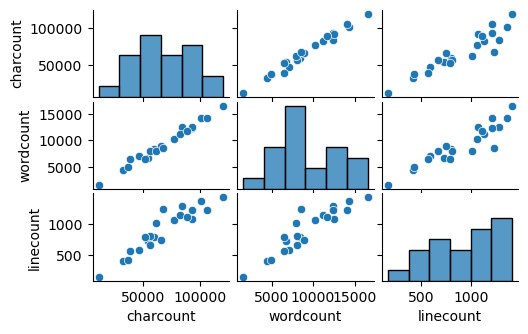

In [166]:
ax = sns.pairplot(df[['charcount', 'wordcount', 'linecount']])
ax.fig.set_figheight(3)
ax.fig.set_figwidth(5)

## Clean up body

In [206]:
# Process the text using @salgado methods
df['processed_text'] = df['body'].apply(utility_salgado.process_text)
df.head()

,path,file,pmid,body,charcount,wordcount,linecount,processed_text
0,./PDFs/heart-agg/18055494.pdf,18055494.pdf,18055494,Clinical and morphological phenotype of the fi...,59755,8386,798,"[clinic, morpholog, phenotyp, filamin, myopath..."
1,./PDFs/heart-agg/22040875.pdf,22040875.pdf,22040875,1. CR YAB AS A CHAPERONE PROTEIN\nThe proteins...,32460,4404,414,"[cr, yab, chaperon, protein, protein, a-a-crys..."
2,./PDFs/heart-agg/22215722.pdf,22215722.pdf,22215722,SPOTLIGHT REVIEW\nAutophagy as a therapeutic t...,54324,6698,732,"[spotlight, review, autophagi, therapeut, targ..."
3,./PDFs/heart-agg/27276715.pdf,27276715.pdf,27276715,Oncotarget53984\nwww.impactjournals.com/oncota...,56315,8029,812,"[oncotarget, www.impactjournals.com/oncotarget..."
4,./PDFs/heart-agg/33467597.pdf,33467597.pdf,33467597,biomolecules\nReview\nBreakdown of Filamentous...,65853,8884,750,"[biomolecul, review, breakdown, filament, myoﬁ..."


In [207]:
# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,cell,1304
1,oxid,901
2,heart,870
3,activ,740
4,patient,700
5,increas,681
6,hypertens,591
7,protein,570
8,diseas,547
9,endotheli,529


## Build model and interpret

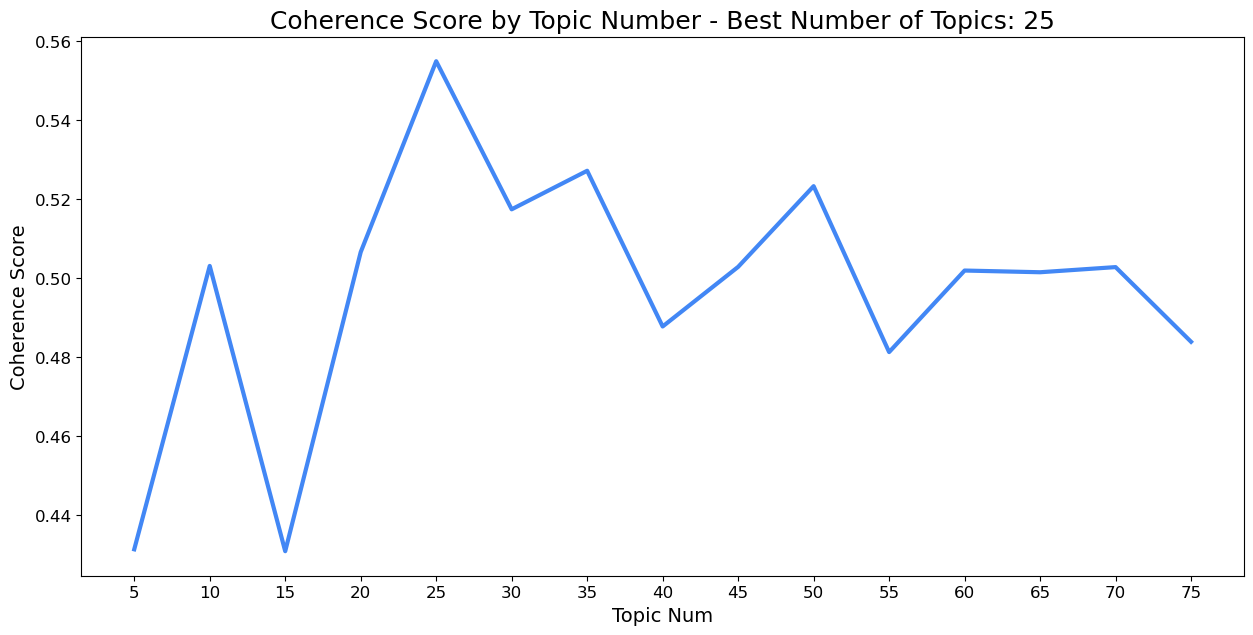

In [208]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

# file_name = 'c_score'

# fig.savefig(
#     file_path + file_name + '.png',
#     dpi=fig.dpi,
#     bbox_inches='tight'
# )

plt.show()

In [217]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names_out()

# Run the nmf model
nmf = NMF(
    n_components=  5,#best_num_topics,#
    init=None, # 'nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0,  
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [218]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = utility_salgado.topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: utility_salgado.whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: utility_salgado.unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.topics

0      vol pp oxid stress ros cvd antioxid ldl medicin
1              hfpef hfref pubm eject fraction obes hf
2     catenin desmin wnt fig rg mutat cancer ubiquitin
3    hypertens ace renal sodium rat receptor ect hi...
4     nox pulmonari pah satoh vascular ros pubm arteri
Name: topics, dtype: object

In [219]:
A = tfidf_vectorizer.transform(texts)
W = pd.DataFrame(nmf.components_)
H = pd.DataFrame(nmf.transform(A))
display(f"W: Words to topics: {W.shape}", f"H: Articles to topics: {H.shape}")

'W: Words to topics: (5, 5000)'

'H: Articles to topics: (22, 5)'

In [220]:
W.columns = tfidf_fn
W.index = [f"Topic{i}" for i in range(W.shape[0])]
W.head()

,aa,ab,abbrevi,abdomin,abe,abil,abl,ablat,abnorm,abolish,...,ﬁnding indic,ﬁnding suggest,ﬁrst,ﬁrst week,ﬁve,ﬂammat,ﬂow,ﬂuenc,ﬂuid,ﬃcult
Topic0,0.010583,0.000000,0.000000,0.000000,0.000000,0.009916,0.000830,0.000000,0.007694,0.001482,...,0.000000,0.002190,0.003185,0.000000,0.000000,0.096765,0.000000,0.010446,0.005846,0.010133
Topic1,0.003050,0.000000,0.000875,0.000000,0.000000,0.000000,0.000406,0.001150,0.001959,0.000000,...,0.000000,0.002219,0.021966,0.003085,0.001941,0.001597,0.002780,0.000000,0.000000,0.000000
Topic2,0.021824,0.030894,0.004043,0.009725,0.000000,0.025714,0.004427,0.002307,0.050146,0.002038,...,0.007644,0.002603,0.007691,0.000339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Topic3,0.000000,0.002548,0.000000,0.005460,0.006408,0.010629,0.004544,0.001344,0.001694,0.010101,...,0.000000,0.003151,0.005242,0.000054,0.003814,0.000000,0.048220,0.000000,0.003111,0.000000
Topic4,0.000000,0.000000,0.011602,0.008845,0.017052,0.007861,0.004273,0.001598,0.005046,0.000876,...,0.001415,0.000177,0.002988,0.002649,0.002008,0.004043,0.003894,0.000769,0.000000,0.000519


In [221]:
H.columns = [topic_df.topics[i] for i in range(W.shape[0])]
H.index = df.pmid
H.head()

,vol pp oxid stress ros cvd antioxid ldl medicin,hfpef hfref pubm eject fraction obes hf,catenin desmin wnt fig rg mutat cancer ubiquitin,hypertens ace renal sodium rat receptor ect hindawi,nox pulmonari pah satoh vascular ros pubm arteri
pmid,,,,,
18055494,0.0,0.000000,0.505112,0.000000,0.000000
22040875,0.0,0.000000,0.520528,0.000000,0.000000
22215722,0.0,0.033976,0.226177,0.079998,0.039771
27276715,0.0,0.000000,0.558591,0.000000,0.000000
33467597,0.0,0.027950,0.425689,0.003675,0.000000


In [222]:
melted_df = pd.melt(H.reset_index(), id_vars = ["pmid"])
melted_df.columns = ['source', 'target', 'value']
melted_df = melted_df.loc[melted_df.value > 0]
melted_df.head()

,source,target,value
6,35550611,vol pp oxid stress ros cvd antioxid ldl medicin,0.043717
7,22525440,vol pp oxid stress ros cvd antioxid ldl medicin,0.183800
10,29333213,vol pp oxid stress ros cvd antioxid ldl medicin,0.591654
11,29861688,vol pp oxid stress ros cvd antioxid ldl medicin,0.043432
12,30745502,vol pp oxid stress ros cvd antioxid ldl medicin,0.016802


In [223]:
from pysankey import sankey

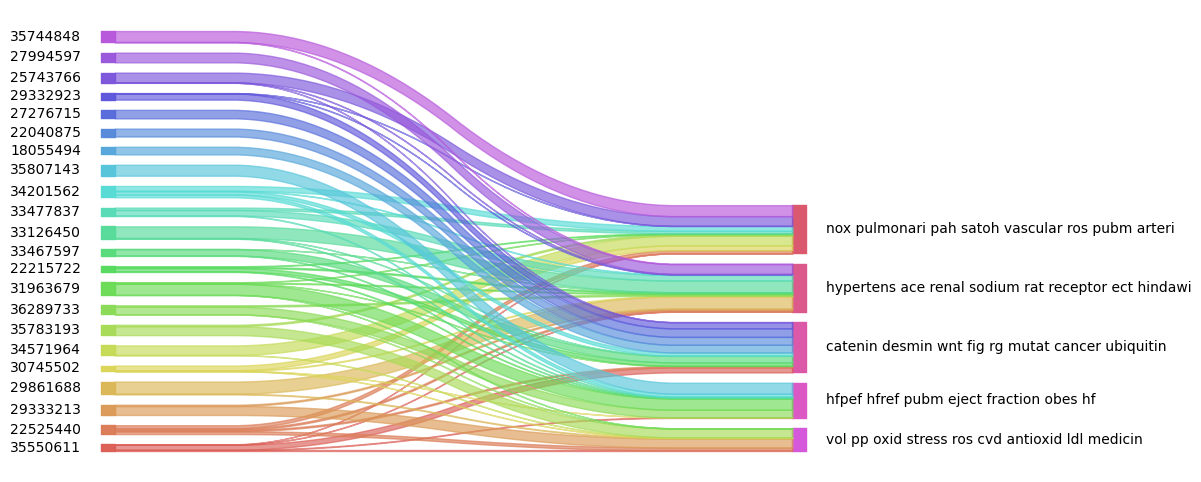

In [224]:
weight = melted_df['value'].values.astype(float)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
# colorDict = {pmid: color for pmid,color in zip(H.index, plt.get_cmap('Paired').colors)}

sankey(
    left=melted_df['source'], 
    right=melted_df['target'],
    rightWeight=weight *2,
    leftWeight=weight* 2, 
    aspect=10, 
    fontsize=10, 
    ax = ax
)

plt.show() # to display